In [ ]:
import numpy as np
import open3d as o3d
import cv2
from matplotlib import pyplot as plt
import pyrealsense2 as rs
from skimage.feature import canny
from skimage import data,morphology, segmentation
from skimage.color import rgb2gray, label2rgb
from skimage.filters import sobel
from skimage.exposure import histogram
import scipy.ndimage as nd
import  multiprocess as mp
import time

In [2]:
import sys  
sys.path.insert(0, '../utils/')

from preprocessing_utils import *
from pcd_utils import *

# imshow(imgs, titles=None, rotate=True)
# depth_filter(depth_image, min_d, max_d, depth_scale)
# bg_remove_color(depth_image, color_image)
# green_color_mask(color, lower=[5,35,0], upper=[75,255,200])
# depth_filter_by_mask(depth, mask)
# color_filter_by_mask(color, mask)

In [3]:
file_path = "../../data/bag_files/leaves/6_12_2022/l1.bag" #R6_G4_R_7_9  R6_G4_L_21_9

FILTERING = True
LOAD_BAG = True
DECIMATION = 4
HOLE_FILLING = True


In [4]:
pipeline = rs.pipeline()
config = rs.config()
if LOAD_BAG:
    config.enable_device_from_file(file_path)

profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()

depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)
if DECIMATION:
    decimation = rs.decimation_filter()
    decimation.set_option(rs.option.filter_magnitude, DECIMATION)
spatial = rs.spatial_filter()
temporal = rs.temporal_filter()
hole_filling = rs.hole_filling_filter()


depth_scale = depth_sensor.get_depth_scale()

align_to = rs.stream.color
align = rs.align(align_to)
    
for i in range(20):
    frames = pipeline.wait_for_frames()
    
#-------------- filtering ----------------

if DECIMATION:
    frames = decimation.process(frames).as_frameset()
    
# Align the depth frame to color frame
aligned_frames = align.process(frames)

# Get aligned frames
aligned_depth_frame = aligned_frames.get_depth_frame().as_video_frame()
color_frame = aligned_frames.get_color_frame().as_video_frame()

# Added by Namal
if FILTERING:
    #aligned_depth_frame = decimation.process(aligned_depth_frame)
    aligned_depth_frame = depth_to_disparity.process(aligned_depth_frame)
    aligned_depth_frame = spatial.process(aligned_depth_frame)
    aligned_depth_frame = temporal.process(aligned_depth_frame)
    aligned_depth_frame = disparity_to_depth.process(aligned_depth_frame)
if HOLE_FILLING:   
    aligned_depth_frame = hole_filling.process(aligned_depth_frame)

# Validate that both frames are valid
if not aligned_depth_frame or not color_frame:
    print("Frame not found")

depth_image1 = np.asanyarray(aligned_depth_frame.get_data())
color_image1 = np.asanyarray(color_frame.get_data())


<Figure size 640x480 with 0 Axes>

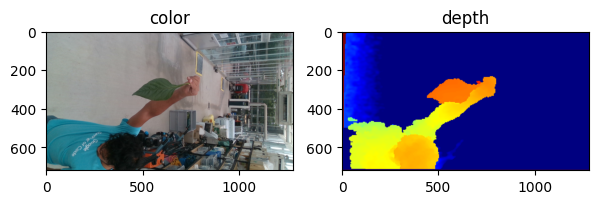

In [5]:
imshow([color_image1,get_colorized_depth(depth_image1)],["color", "depth"], False)

In [6]:
pc = rs.pointcloud()
pc.map_to(color_frame)

points = pc.calculate(aligned_depth_frame)
verts1 =  np.asanyarray(points.get_vertices())
verts1 = verts1.view(np.float32).reshape(720, 1280, 3)
print(color_image1.shape)
print(verts1.shape)

(720, 1280, 3)
(720, 1280, 3)


In [8]:
# offset = 2
# res_x_mn, res_x_mx, res_y_mn, res_y_mx = 400, 700, 200, 400

# # color_image =color_image1[res_y_mn: res_y_mx, res_x_mn:res_x_mx]
# # depth_image =depth_image1[res_y_mn: res_y_mx, res_x_mn:res_x_mx]
# # verts =verts1[res_y_mn: res_y_mx, res_x_mn:res_x_mx]

# color_image =color_image1[res_y_mn:res_y_mx:offset, res_x_mn:res_x_mx:offset]
# depth_image =depth_image1[res_y_mn:res_y_mx:offset, res_x_mn:res_x_mx:offset]
# verts =verts1[res_y_mn:res_y_mx:offset, res_x_mn:res_x_mx:offset]

# print(color_image.shape)
# print(depth_image.shape)
# print(verts.shape)
# imshow([color_image1,depth_image1, color_image, depth_image], ['','','',''], False)

depth_image = depth_image1
color_image = color_image1

NameError: name 'verts' is not defined

<Figure size 640x480 with 0 Axes>

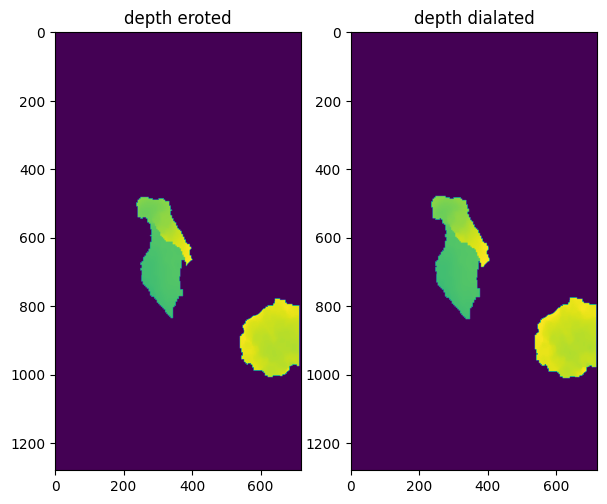

In [9]:
## ---------- PRE PROCESSING ---------------- #


GREEN_MASK = True
ER_MASK_COLOR = False
ER_MASK_DEPTH = False
DEPTH_FILTERING = True

# imshow([color_image, depth_image],["color", "depth"])

MASK = False


if DEPTH_FILTERING:
    # depth filtering
    depth_fed = depth_filter(depth_image, 0.5, 0.95, depth_scale)
    
    KERNAL_SIZE = 3
    kernel = np.ones((KERNAL_SIZE, KERNAL_SIZE), np.uint8)  
    # Using cv2.erode() method 
    depth_fe = cv2.erode(depth_fed, kernel, cv2.BORDER_REFLECT, iterations=3)
    depth_fed = cv2.dilate(depth_fe, kernel, iterations=3)
    imshow([ depth_fe, depth_fed], ["depth eroted", "depth dialated"])
    
# get green mask
if GREEN_MASK:
    #depth filtered color
    color_d  = color_filter_by_mask(color_image, depth_fed)
    mask = green_color_mask(color_d, lower=[10,35,0], upper=[75,255,200])
    MASK = True
    
# get region and edge based mask
if ER_MASK_COLOR:
    #depth filtered color
    color_d  = color_filter_by_mask(color_image, depth_fed)
    mask = region_and_edge_based_segmentation_mask(color_d, True, m1=10, m2=150, ret='markers')
    MASK = True

if ER_MASK_DEPTH:
    mask = region_and_edge_based_segmentation_mask(depth_image)
    MASK = True

if MASK:
    depth_m = depth_filter_by_mask(depth_image, mask)
    color_m = color_filter_by_mask(color_image, mask)
    verts_m = color_filter_by_mask(verts, mask)

imshow([ depth_fed, mask], ['Depth Filtered','mask '])
    
imshow([ color_image, depth_image, depth_m, color_m,], ['color','depth', "depth masked", "color_masked"])
    
# background remove color
# color_m = bg_remove_color(depth_m, color_m)
# imshow([color_m, get_colorized_depth(depth_m)], ["color bg_", "depth erode"])
    

color = color_m
depth = depth_m

In [10]:
## intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, intrinsics.fx,
                                            intrinsics.fy, intrinsics.ppx,
                                            intrinsics.ppy)
flip_transform = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
print(intrinsic)
pcd = o3d.geometry.PointCloud()
color = o3d.geometry.Image(color)
depth = o3d.geometry.Image(depth)


# rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
#     color,
#     depth,
#     depth_scale=1.0 / 1000, # ToDo
#     depth_trunc= clipping_distance_in_meters,
#     convert_rgb_to_intensity=False)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color,
    depth,
    depth_scale=1000,
    depth_trunc=4,
    convert_rgb_to_intensity=False)

temp = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
temp.transform(flip_transform)
pcd.points = temp.points
pcd.colors = temp.colors
pcd = pcd.voxel_down_sample(voxel_size=0.001)
o3d.visualization.draw_geometries([pcd])

NameError: name 'intrinsics' is not defined

In [1]:
pcd1 = o3d.geometry.PointCloud()
vresx, vresy = verts_m.shape[1], verts_m.shape[0]
print(vresx, vresy)
pcd1.points = o3d.utility.Vector3dVector(verts_m.reshape(vresx*vresy,3))
print(len(pcd1.points))
pcd2 = pcd1.voxel_down_sample(voxel_size=0.001)
print(len(pcd2.points))
print(np.asanyarray(pcd2.points)[1])
print(verts_m[0][0])
#o3d.visualization.draw_geometries([pcd2])
# print(pcd2.)
o3d.visualization.draw_geometries([pcd2])


NameError: name 'o3d' is not defined

In [37]:
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.001)
o3d.visualization.draw_geometries([voxel_down_pcd])

In [38]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

print("Statistical oulier removal")
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=10, std_ratio=1)
display_inlier_outlier(voxel_down_pcd, ind)
inlier_cloud = voxel_down_pcd.select_by_index(ind)

Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [45]:
print("Radius oulier removal")
cl, ind = pcd2.remove_radius_outlier(nb_points=20, radius=0.01)
display_inlier_outlier(voxel_down_pcd, ind)
inlier_cloud = voxel_down_pcd.select_by_index(ind)

Radius oulier removal
Showing outliers (red) and inliers (gray): 


In [ ]:
# VS, MIN_POINTS, EPS =0.02, 80, 0.08  #stichted cloud
VS, MIN_POINTS, EPS =0.001, 100, 0.01 #rgbd pcd

pcd_vd1 = pcd.voxel_down_sample(voxel_size=VS)

cl, ind = pcd_vd1.remove_radius_outlier(nb_points=20, radius=0.005)
display_inlier_outlier(pcd_vd1, ind)
pcd_vd1 = pcd_vd1.select_by_index(ind) 

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd_vd1.cluster_dbscan(eps=EPS, min_points=MIN_POINTS, print_progress=True)) # 0.05 ,80
    
mask = np.where((labels > -1), 1, 0)
# mask = np.where((labels < 0) | (labels >= labels.max()-5), 0, 1)
m=list(np.nonzero(mask)[0])
pcd_vd2 = pcd_vd1.select_by_index(m)
    
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_vd1.colors = o3d.utility.Vector3dVector(colors[:, :3])
pcd_vd1.translate((0.5, 0, 0))
o3d.visualization.draw_geometries([pcd_vd1, pcd_vd2])

In [91]:
# o3d.visualization.draw_geometries([inlier_cloud])
# inlier_cloud.estimate_normals()
o3d.visualization.draw_geometries([inlier_cloud])
pcd.estimate_normals()

In [194]:
cloud = pcd_vd2
alpha = 0.03
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cloud, alpha)
mesh.compute_vertex_normals()
mesh.remove_duplicated_triangles()
mesh.remove_duplicated_vertices()
mesh.sample_points_uniformly()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=False)
print(mesh.get_surface_area()*10000)

alpha=0.030
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra 

In [197]:
cloud = pcd_vd2 # pcd #voxel_down_pcd # pcd2 voxel_down_pcd
cloud.estimate_normals()
distances = cloud.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist #
# radii = [0.005, 0.01, 0.02, 0.04]
# inlier_cloud.estimate_normals()
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(cloud, o3d.utility.DoubleVector([radius, radius * 2]))
o3d.visualization.draw_geometries([bpa_mesh], mesh_show_back_face=True)
print(bpa_mesh.get_surface_area()*10000)


47.10337095301318


In [165]:
cloud = pcd_vd2 #pcd
p_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson( cloud, depth=5, width=0, scale=1, linear_fit=False)
o3d.visualization.draw_geometries([p_mesh], mesh_show_back_face=False)
print(p_mesh.get_surface_area()*10000)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
163.85233902694537


In [ ]:
inlier_cloud.get

In [13]:
number_of_processes = 8

def findTri(nv, trs):
    while len(nv)>0:
        p=nv.__getitem__(0)

        i=p[0]
        j=p[1]
        nv.remove(p)
        try:
            if i-1 >= 0 and j-1 >= 0 and pts[i-1][j-1]>0:
                nv.remove([i-1,j-1]) if [i-1, j-1] in nv else None
                if pts[i-1][j]>0:
                    trs.append([[i-1,j-1],[i-1, j], p])
                    nv.remove([i-1, j]) if [i-1, j] in nv else None
                if pts[i][j-1]>0:
                    trs.append([[i-1,j-1],[i, j-1], p])
                    nv.remove([i, j-1]) if [i, j-1] in nv else None
            if i-1 >= 0 and j+1 < pts.shape[1] and pts[i-1][j+1]>0:
                nv.remove([i-1,j+1]) if [i-1, j+1] in nv else None
                if pts[i-1][j]>0:
                    trs.append([[i-1, j],[i-1,j+1], p])
                    nv.remove([i-1, j]) if [i-1, j] in nv else None
                if pts[i][j+1]>0:
                    trs.append([[i-1, j+1], p, [i,j+1]])
                    nv.remove([i, j+1]) if [i, j+1] in nv else None
            if i+1 < pts.shape[0] and j+1 < pts.shape[1] and pts[i+1][j+1]>0:
                nv.remove([i+1,j+1]) if [i+1, j+1] in nv else None
                if pts[i+1][j]>0:
                    trs.append([p,[i+1, j],[i+1,j+1]])
                    nv.remove([i+1,j]) if [i+1, j] in nv else None
                if pts[i][j+1]>0:
                    trs.append([p, [i,j+1], [i+1, j+1]])
                    nv.remove([i, j+1]) if [i, j+1] in nv else None
            if i+1 < pts.shape[0] and j-1 >= 0 and pts[i+1][j-1]>0:
                nv.remove([i+1,j-1]) if [i+1, j-1] in nv else None
                if pts[i+1][j]>0:
                    trs.append([p,[i+1, j],[i+1,j-1]])
                    nv.remove([i+1,j]) if [i+1, j] in nv else None
                if pts[i][j-1]>0:
                    trs.append([p, [i,j-1], [i+1, j-1]])
                    nv.remove([i, j-1]) if [i, j-1] in nv else None
        except:
            continue
    return trs




In [14]:
def callback(result):
    print(len(trs))
    print(trs[0])
    print("timetaken: ", str(time.time()-t1))
    pool.close()
    pool.join()

pts = np.array(mask) #ps3
#trs=[]
r = np.argwhere(pts>0)
print(len(r))
#nv = r.tolist()
man = mp.Manager()
pool = mp.Pool(processes = number_of_processes)
nv = man.list(r.tolist())
trs = man.list()
t1= time.time()

print(len(nv))

pool.apply_async(findTri, (nv,trs), callback=callback)

4665
4665


Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\90953393\Anaconda3\envs\Imaging2\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\90953393\Anaconda3\envs\Imaging2\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\90953393\Anaconda3\envs\Imaging2\lib\site-packages\multiprocess\pool.py", line 592, in _handle_results
    cache[job]._set(i, obj)
  File "C:\Users\90953393\Anaconda3\envs\Imaging2\lib\site-packages\multiprocess\pool.py", line 776, in _set
    self._callback(self._value)
  File "C:\Users\90953393\AppData\Local\Temp\ipykernel_9856\1662024551.py", line 3, in callback
  File "<string>", line 2, in __getitem__
  File "C:\Users\90953393\Anaconda3\envs\Imaging2\lib\site-packages\multiprocess\managers.py", line 850, in _callmethod
    raise convert_to_error(kind, result)
IndexError: list index out of range


0


In [28]:
def heron(a,b,c):  
    s = (a + b + c) / 2   
    area = (s*(s-a)*(s-b)*(s-c)) ** 0.5        
    return area

def distance3d(x1,y1,z1,x2,y2,z2):    
    a=(x1-x2)**2+(y1-y2)**2 + (z1-z2)**2
    d= a ** 0.5  
    return d  

def areatriangle3d(p1, p2, p3):  
    a=distance3d(p1[0],p1[1],p1[2],p2[0],p2[1],p2[2])  
    b=distance3d(p2[0],p2[1],p2[2],p3[0],p3[1],p3[2])  
    c=distance3d(p3[0],p3[1],p3[2],p1[0],p1[1],p1[2])  
    A = heron(a,b,c)  
    return A


pool.terminate
pool.close()
t1= time.time()
area = 0
print("# Trs: ", str(len(trs)))
for t in trs:
    p1=verts_[t[0][0], t[0][1]]
    p2=verts_[t[1][0], t[1][1]]
    p3=verts_[t[2][0], t[2][1]]
    area= area+ areatriangle3d(p1, p2, p3)
    #print(view_obj[t[0][0], t[0][1]])
    #break
print("timetaken: ", str(time.time()-t1))

area = area*1000000

print(area, "mm2")
error =  (area - 62370)*100/ 62370
print("error", error)

# Trs:  0
timetaken:  0.0010178089141845703
0 mm2
error -100.0


In [42]:
pts = np.array(mask) #ps3
print(pts.shape)
r = np.argwhere(pts>0)
print(r.shape)
print(pts[0])
print(r[0])

(175, 175)
(4662, 2)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 33 101]
